In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define paths
train_path = "D:\\Users\\ahad\\Downloads\\Image Classification Dataset\\seg_train"
test_path = "D:\\Users\\ahad\\Downloads\\Image Classification Dataset\\seg_test"
pred_path = "D:\\Users\\ahad\\Downloads\\Image Classification Dataset\\seg_pred"

# Define image size and batch size
img_size = (150, 150)
batch_size = 32

# Create data generators for training and testing
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_path, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_path, target_size=img_size, batch_size=batch_size, class_mode='categorical')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


Training Dataset


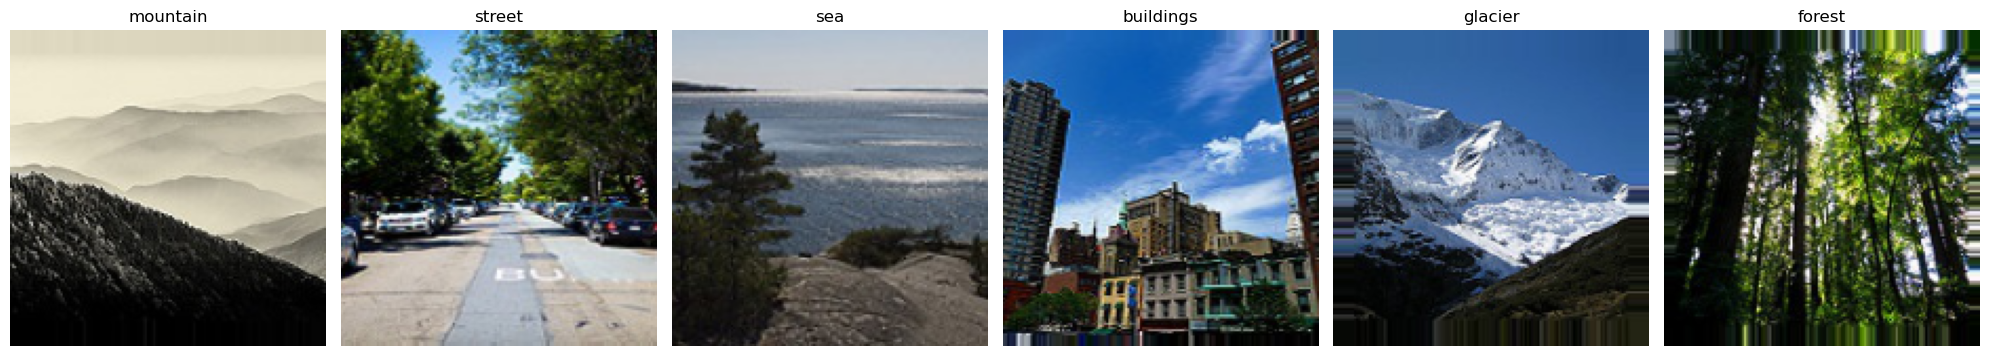

Testing Dataset


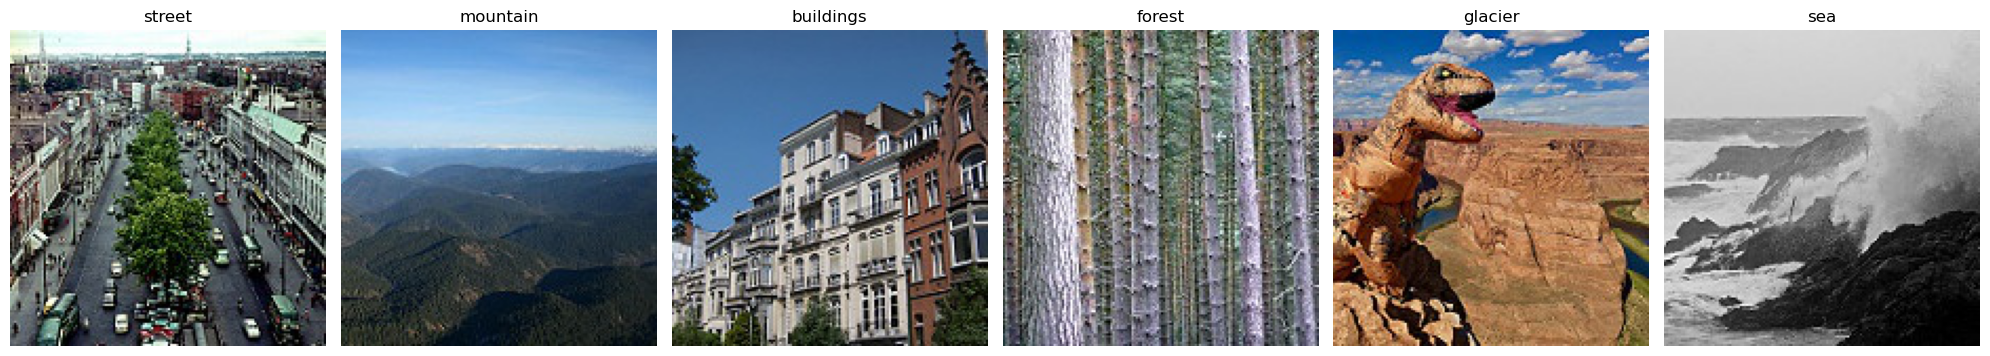

In [3]:
# Get class labels
class_labels = list(train_generator.class_indices.keys())

# Function to plot images
def plot_images(images_arr, labels):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(20,20))
    axes = axes.flatten()
    for img, lbl, ax in zip(images_arr, labels, axes):
        ax.imshow(img)
        ax.set_title(lbl)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Function to get one image per class
def get_images(generator):
    images = []
    labels = []
    while len(images) < len(class_labels):
        batch_images, batch_labels = next(generator)
        batch_labels = np.argmax(batch_labels, axis=-1)  # convert one-hot encoded labels to single integer labels
        for img, lbl in zip(batch_images, batch_labels):
            if lbl not in labels:
                images.append(img)
                labels.append(lbl)
    labels = [class_labels[i] for i in labels]  # convert integer labels to actual class labels
    return images, labels

# Get and plot training images
print("Training Dataset")
train_images, train_labels = get_images(train_generator)
plot_images(train_images, train_labels)

# Get and plot testing images
print("Testing Dataset")
test_images, test_labels = get_images(test_generator)
plot_images(test_images, test_labels)


In [4]:
# Load the VGG16 model but exclude the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [5]:
# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add new top layers
x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(6, activation='softmax')(x)

# Define the new model
model = Model(inputs=base_model.input, outputs=predictions)


In [6]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
# Define callbacks (optional)
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True)
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

In [8]:
# Train the model
history = model.fit(train_generator, epochs=4, validation_data=test_generator, callbacks=[checkpoint, early_stopping])

Epoch 1/4


439/439 [==============================] - ETA: 0s - loss: 0.6517 - accuracy: 0.7569

C:\Users\ahadk\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


439/439 [==============================] - 2213s 5s/step - loss: 0.6517 - accuracy: 0.7569 - val_loss: 0.3974 - val_accuracy: 0.8437
Epoch 2/4
439/439 [==============================] - 2168s 5s/step - loss: 0.5017 - accuracy: 0.8156 - val_loss: 0.3636 - val_accuracy: 0.8673
Epoch 3/4
439/439 [==============================] - 2328s 5s/step - loss: 0.4605 - accuracy: 0.8380 - val_loss: 0.3541 - val_accuracy: 0.8680
Epoch 4/4
439/439 [==============================] - 14030s 32s/step - loss: 0.4334 - accuracy: 0.8405 - val_loss: 0.3496 - val_accuracy: 0.8627


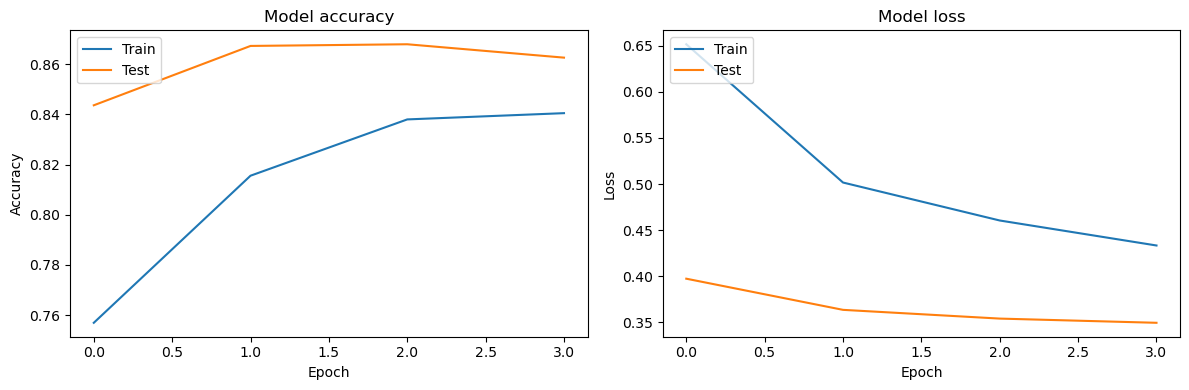

In [9]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()


In [10]:
# Evaluate the model on the prediction set
pred_datagen = ImageDataGenerator(rescale=1./255)
pred_generator = pred_datagen.flow_from_directory(pred_path, target_size=img_size, batch_size=batch_size, class_mode='categorical')
# Make predictions on the prediction set
predictions = model.predict(pred_generator)
#pred_loss, pred_acc = model.evaluate(pred_generator)
#print(f"Prediction Accuracy: {pred_acc}")

Found 7301 images belonging to 1 classes.
229/229 [==============================] - 1059s 5s/step


1/1 [==============================] - 4s 4s/step


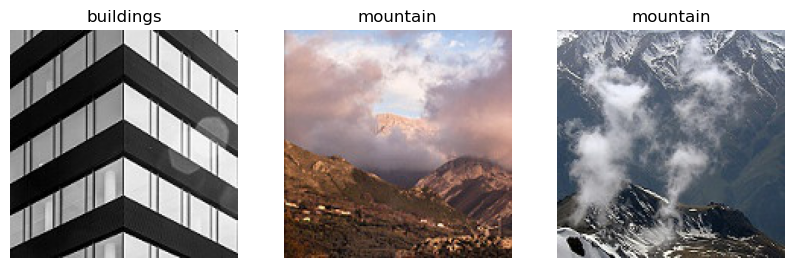

In [11]:
images, _ = next(pred_generator)

# Make predictions on the first batch
predictions = model.predict(images)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
predicted_labels = [class_labels[i] for i in predicted_classes]

# Plot the first 3 images with their predicted labels
plt.figure(figsize=(10, 10))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(images[i])
    plt.title(predicted_labels[i])
    plt.axis('off')
plt.show()